In [75]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\minji\AppData\Local\Temp/ipykernel_11420/314071377.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [80]:
# create data

nPerClust = 100
blur = 1 # how spread out data are from the cluster mean

A = [1, 1]
B = [5, 1]
C = [3, -1]

a = [A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur] # 2, 100
b = [B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur] # 2, 100
c = [C[0]+np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur] # 2, 100

labels_np = np.vstack((np.zeros((nPerClust, 1)), # 0
                       np.ones((nPerClust, 1)), # 1
                       np.full((nPerClust, 1), 2))) # 2

data_np = np.hstack((a, b, c)).T # (2, 300).T -> (300, 2)
data = torch.tensor(data_np).float() # 300, 2
labels = torch.squeeze(torch.tensor(labels_np).long()) # 300, 1

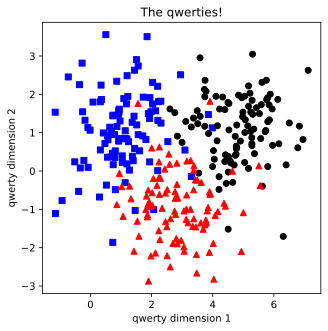

In [82]:
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1], 'r^')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [83]:
ANNclassify = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 3)
)

ANNclassify

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=3, bias=True)
)

In [84]:
lr = 0.01
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=lr)

In [89]:
def train(data, num_epochs=10000):
    
    losses = torch.zeros(num_epochs)
    ongoingAcc = []
    
    for i in tqdm(range(num_epochs)):
        
        y_pred = ANNclassify(data)
        loss = loss_func(y_pred, labels)
        losses[i] = loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute accuracy
        matches = torch.argmax(y_pred, axis=1) == labels
        matchesNumeric = matches.float()
        accuracyPct = 100*torch.mean(matchesNumeric)
        ongoingAcc.append(accuracyPct)
        
    predictions = ANNclassify(data)
    predlabels = torch.argmax(predictions, axis=1)
    totalacc = 100*torch.mean((predlabels == labels).float())
    
    return losses, ongoingAcc, predictions, predlabels, totalacc

In [90]:
losses, ongoingAcc, predictions, predlabels, totalacc = train(data, 10000)

100%|██████████| 10000/10000 [00:20<00:00, 478.46it/s]


Final accuracy: 93.0%


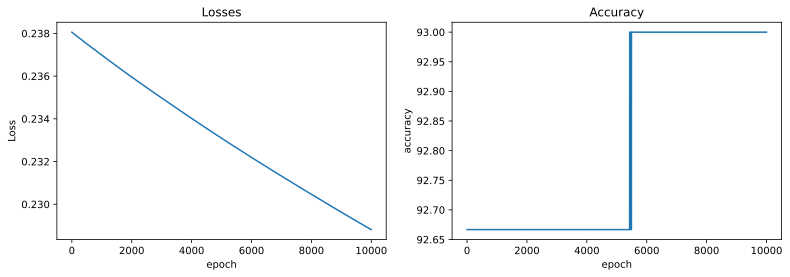

In [91]:
# report accuracy
print(f'Final accuracy: {totalacc}%')

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()

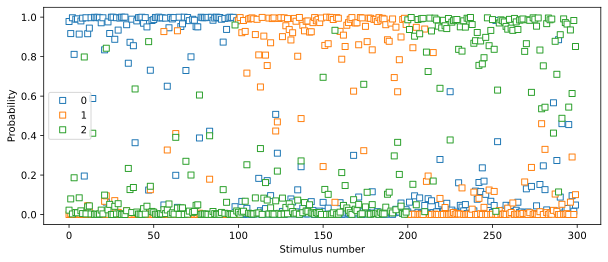

In [93]:
# plot the raw model outputs
sm = nn.Softmax(1)
fig = plt.figure(figsize=(10,4))

plt.plot(sm(predictions).detach(),'s',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['0','1','2'])
plt.show()